In [38]:
import starfile
import mrcfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

df = pd.read_json('data_for_training.json')

idx_for_check = 4

df = df.iloc[idx_for_check]
training_set_name = df['dataset_name']
map_path = df['map_path']
mask_path = df['mask_path']

meta_star = df['meta_data_path']

data_dir = df['raw_data_dir']

meta = starfile.read(meta_star)


In [39]:
def mask_and_proj(path1, path2):
    projection_command = f"relion_project --i {path1} --o {path2}\
        --rot {meta['rlnAngleRot'][idx]} --tilt {meta['rlnAngleTilt'][idx]} --psi {meta['rlnAnglePsi'][idx]}\
        --xoff {meta['rlnOriginX'][idx]}, --yoff {meta['rlnOriginX'][idx]} --ctf"
    os.system(projection_command)

In [40]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve

idx = 1
raw_path = meta['rlnImageName'][idx].split('@')[-1]
particle_idx = int(meta['rlnImageName'][idx].split('@')[0]) - 1
raw_name = raw_path.split('/')[-1]
raw_path = f"{data_dir}{raw_name}"

with mrcfile.open(raw_path) as mrc:
    raw = mrc.data[particle_idx]

mask_proj_name = f'{particle_idx}@{raw_name}'
mask_proj_path = f'tmp/mask_{mask_proj_name}'

map_proj_name = f'{particle_idx}@{raw_name}'
map_proj_path = f'tmp/map_{map_proj_name}'

mask_and_proj(mask_path, mask_proj_path)

mask_and_proj(map_path, map_proj_path)

with mrcfile.open(mask_proj_path) as mrc:
    mask_proj = mrc.data
with mrcfile.open(map_proj_path) as mrc:
    map_proj = mrc.data

mask_proj.setflags(write=1)
threshold =10
number_pixel_to_extend = 5
len_of_fill = number_pixel_to_extend*2 +1
mask_proj[mask_proj <= threshold] = 2
mask_proj[mask_proj > threshold] = 1
fil = np.full((len_of_fill,len_of_fill), -1)
fil[number_pixel_to_extend,number_pixel_to_extend] = len_of_fill*len_of_fill-1
contour = convolve(mask_proj, fil, mode='reflect') > 0
mask_proj[contour == True] = 3
mask_proj = mask_proj.astype('uint8')


 Reading map: particleSeg_recon/empiar_10126/MaskCreate/job012/mask.mrc
 Done reading map!


         The value in the input image header (= 1.046) is used instead.


 Done writing tmp/mask_1@Tit1_HEA_22k_hM4_GlwQF_090117_2_0005_ali_DW.mrcs
 Reading map: particleSeg_recon/empiar_10126/Refine3D/job009/run_ct23_class001.mrc
 Done reading map!


         The value in the input image header (= 1.046) is used instead.


 Done writing tmp/map_1@Tit1_HEA_22k_hM4_GlwQF_090117_2_0005_ali_DW.mrcs


In [41]:
def clean_particles():
    print(len(meta))
    raw_paths = pathlib.Path(data_dir).glob('*.mrcs')
    meta['rlnImageName_raw'] = meta['rlnImageName'].str.split('/').str[-1]
    file_names = []
    for item in raw_paths:
        file_names.append(str(item.name))
    index_to_drop = []
    for index, row in meta.iterrows():
        if row['rlnImageName_raw'] not in list(file_names):
            index_to_drop.append(index)

    meta = meta.drop(index_to_drop)
    meta = meta.drop(columns='rlnImageName_raw')
    len(meta)
    starfile.write(meta, f'{meta_star}_cleaned')

Text(0.5, 1.0, 'mask applied to lowpass')

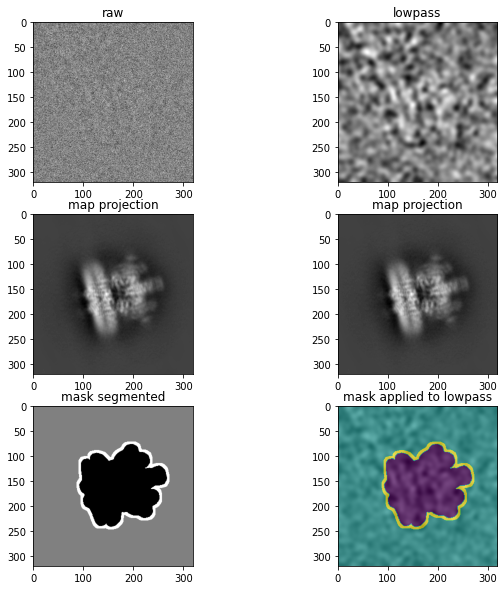

In [42]:
fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].imshow(raw, cmap='gray')
ax[0,0].set_title('raw')

ax[0,1].imshow(gaussian_filter(raw, sigma=5), cmap='gray')
ax[0,1].set_title('lowpass')

ax[1,0].imshow(map_proj, cmap='gray')
ax[1,0].set_title('map projection')

ax[1,1].imshow(map_proj, cmap='gray')
ax[1,1].set_title('map projection')

ax[2,0].imshow(mask_proj, cmap='gray')
ax[2,0].set_title('mask segmented')

ax[2,1].imshow(gaussian_filter(raw, sigma=5), cmap='gray')
ax[2,1].imshow(mask_proj, alpha=0.7)
ax[2,1].set_title('mask applied to lowpass')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


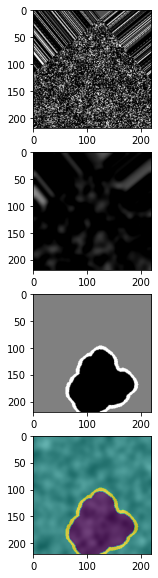

In [21]:
import tensorflow as tf
import random as rn
seed = 131

# tf.random.set_seed(seed)
# #tf.kera.preprocessing.image.
# np.random.seed(seed)
# rn.seed(seed)

shift = 0.3
raw_shift = np.stack((raw,)*3, axis=-1)

#raw_shift = tf.image.random_crop(raw_shift, size = seed=seed)
h, w = raw_shift.shape[0], raw_shift.shape[1]
tx = np.random.uniform(-shift, shift)*h
ty = np.random.uniform(-shift, shift)*w
raw_shift = tf.keras.preprocessing.image.apply_affine_transform(raw_shift, tx,ty , channel_axis=2, fill_mode='nearest') 
mask_proj_shift = np.expand_dims(mask_proj, 2)
mask_proj_shift = tf.keras.preprocessing.image.apply_affine_transform(mask_proj_shift, tx,ty , channel_axis=2, fill_mode='nearest') 

fig, ax = plt.subplots(4,1,figsize=(10,10))

ax[0].imshow(raw_shift, cmap='gray')
ax[1].imshow(gaussian_filter(raw_shift, sigma=5), cmap='gray')
ax[2].imshow(mask_proj_shift, cmap='gray')
ax[3].imshow(gaussian_filter(raw, sigma=5), cmap='gray')
ax[3].imshow(mask_proj_shift, alpha=0.7)


In [1]:
import os
import matplotlib.pyplot as plt